In [1]:
!pip install grad-cam lime torch torchvision matplotlib shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
import argparse
import os
import json
import gc
import cv2
import numpy as np
import torch
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise, KPCA_CAM

)
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap
from skimage.segmentation import mark_boundaries
from lime import lime_image
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split


In [3]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Load ImageNet labels into a list
with open("imagenet_classes.txt", "r") as f:
    imagenet_labels = [s.strip() for s in f.readlines()]

--2025-02-01 16:49:45--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-02-01 16:49:46 (126 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True, progress=False)
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

preview = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

def preprocess(image_path):
  image = Image.open(image_path).convert('RGB')
  return transform(image).unsqueeze(0)

# Load an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return preview(image)

Occlusion Sensitivity Heatmap (squares)

In [6]:
def occlusion_sensitivity(model, image_tensor, patch_size=30, stride=10, target_class=None):
    _, _, height, width = image_tensor.shape
    heatmap = np.zeros((height, width))
    counts = np.zeros((height, width))
    with torch.no_grad():
        original_output = model(image_tensor)
        if target_class is None:
            target_class = torch.argmax(original_output).item()

        # Slide the patch across the image
        for y in range(0, height, stride):
            for x in range(0, width, stride):
                # Clone the image and apply occlusion
                occluded_image = image_tensor.clone()
                occluded_image[:, :, y:y+patch_size, x:x+patch_size] = 0  # Replace patch with black

                # Get model's output for occluded image
                output = model(occluded_image)
                score = original_output[0, target_class].item() - output[0, target_class].item()

                # Update the heatmap
                heatmap[y:y+patch_size, x:x+patch_size] += score
                counts[y:y+patch_size, x:x+patch_size] += 1

    # Normalize the heatmap to [0, 1], using counts to handle overlapping patches
    counts[counts == 0] = 1
    heatmap = heatmap / counts  # Avoid division by zero
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    #heatmap = 1 - heatmap
    return heatmap


def get_occlusion_sensitivity_heatmap(image_path):
    patch_size = 30
    stride = 10
    target_class = None
    image_tensor = preprocess(image_path)
    image_tensor = image_tensor.to(device)
    return occlusion_sensitivity(model, image_tensor, patch_size=patch_size, stride=stride, target_class=target_class)

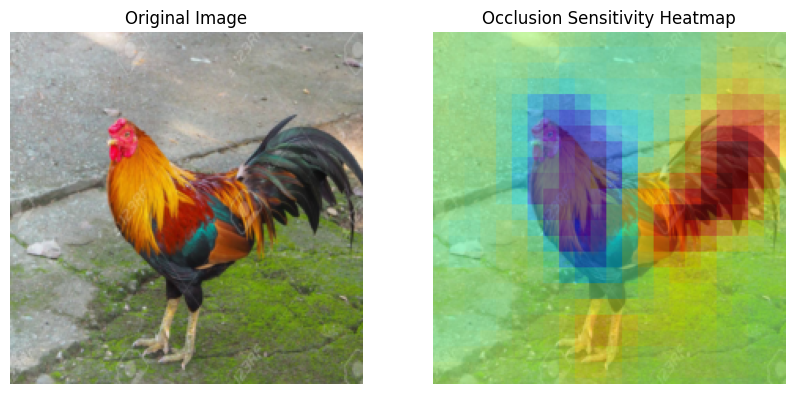

Model prediction: cock


In [9]:
image_path = './child1.jpeg'
original_image = load_image(image_path)
heatmap_OS = get_occlusion_sensitivity_heatmap(image_path)
# Visualize the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.imshow(heatmap_OS, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.title("Occlusion Sensitivity Heatmap")
plt.show()

model_output = model(preprocess(image_path).to(device))
predicted_class_index = torch.argmax(model_output).item()
predicted_class_label = imagenet_labels[predicted_class_index]
print(f"Model prediction: {predicted_class_label}")

LIME

In [10]:
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def get_lime_heatmap(image_path):
  image = load_image(image_path)
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(np.array(image),
                                          batch_predict, # classification function
                                          top_labels=5,
                                          hide_color=0,
                                          num_samples=1000)
  _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
  return mask

  0%|          | 0/1000 [00:00<?, ?it/s]

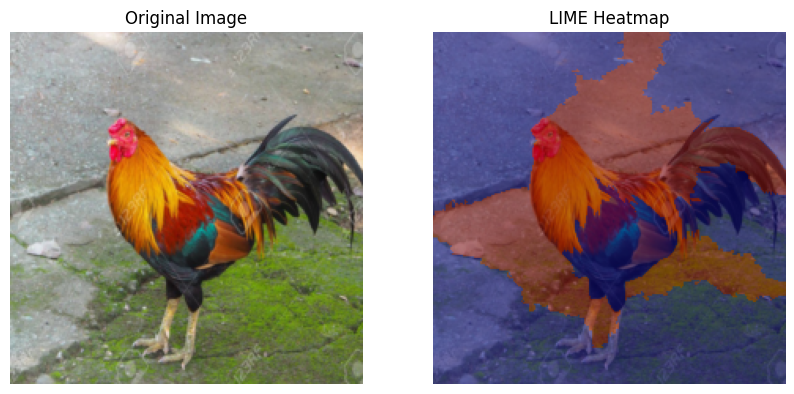

In [11]:
# image_path = './sample_data/images/kogut.jpg'
original_image = load_image(image_path)
mask_LIME = get_lime_heatmap(image_path)
# Visualize the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.imshow(mask_LIME, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.title("LIME Heatmap")
plt.show()

Grad-CAM

In [12]:
CAM_methods = {
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
    }

def get_CAM_heatmap(image_path, method):
  # Choose the target layer you want to compute the visualization for.
  # Usually this will be the last convolutional layer in the model.
  # Some common choices can be:
  # Resnet18 and 50: model.layer4
  # VGG, densenet161: model.features[-1]
  # mnasnet1_0: model.layers[-1]
  # You can print the model to help chose the layer
  # You can pass a list with several target layers,
  # in that case the CAMs will be computed per layer and then aggregated.
  # You can also try selecting all layers of a certain type, with e.g:
  # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
  # find_layer_types_recursive(model, [torch.nn.ReLU])
  target_layers = [model.layer4]
  cam_algorithm = CAM_methods[method]
  image_tensor = preprocess(image_path).to(device)
  with cam_algorithm(model=model,
                            target_layers=target_layers) as cam:

              grayscale_cam = cam(input_tensor=image_tensor,
                                  targets=None,
                                  aug_smooth=False,
                                  eigen_smooth=False)




              grayscale_cam = grayscale_cam[0, :]

              # Free up memory for cam related objects
              del cam
              gc.collect()
              torch.cuda.empty_cache()

              return grayscale_cam

100%|██████████| 64/64 [00:00<00:00, 66.25it/s]


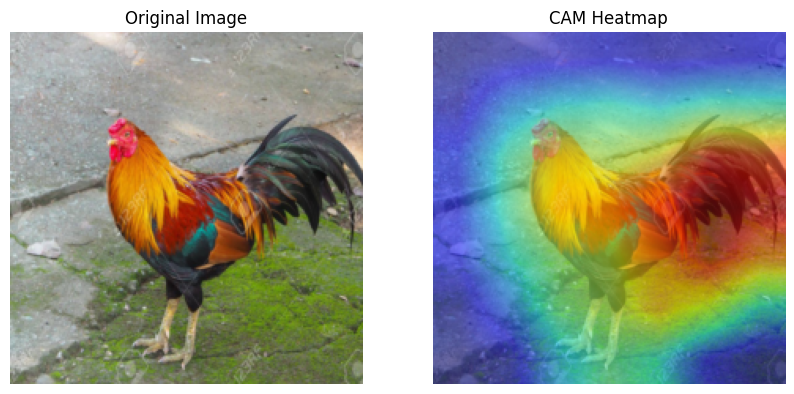

In [14]:
# image_path = './sample_data/images/kogut.jpg'
original_image = load_image(image_path)
mask_CAM = get_CAM_heatmap(image_path, "ablationcam")
# Visualize the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.imshow(mask_CAM, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.title("CAM Heatmap")
plt.show()

SHAP

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

model1 = ResNet50(weights="imagenet")

X, y = shap.datasets.imagenet50()
X= np.clip(X, 0, 255).astype(np.uint8)

background = torch.stack([
    torch.tensor(img).permute(2, 0, 1).float().to(device) / 255.0
    for img in X
])
def f(x):

    tmp = x.copy()
    tmp = preprocess_input(tmp)
    return model1.predict(tmp)

def get_shap_heatmap(image_path):

    masker = shap.maskers.Image("inpaint_telea", X[0].shape)
    explainer = shap.Explainer(f, masker, output_names=imagenet_labels)


    input_tensor = preprocess(image_path).cpu()
    input_tensor_np = input_tensor.squeeze(0).permute(1, 2, 0).numpy()

    input_tensor_np = np.expand_dims(input_tensor_np, axis=0)
    shap_values = explainer(input_tensor_np, max_evals=100, batch_size=50)
    return shap_values

image_path = './sample_data/images/kogut.jpg'
heatmap_shap = get_shap_heatmap(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 0/98 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


PartitionExplainer explainer: 2it [00:19, 19.09s/it]               


In [ ]:
image_path = './sample_data/images/kogut.jpg'
original_image = load_image(image_path)
heatmap_shap = get_shap_heatmap(image_path)
shap.image_plot(heatmap_shap)
# Visualize the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(original_image)
# plt.imshow(heatmap_shap, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.title("CAM Heatmap")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Eye fixation map

In [ ]:
def load_heatmap(image_path):
    image = Image.open(image_path).convert('')
    return preview(image)

def eye_fixation_heatmap(image_path, heatmap_path):
    heatmap = load_heatmap(heatmap_path)

    heatmap = np.array(heatmap)

    # Multiply all pixel values by 2
    # heatmap = heatmap * 2

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # heatmap = Image.fromarray((255 * heatmap).astype(np.uint8))

    return heatmap

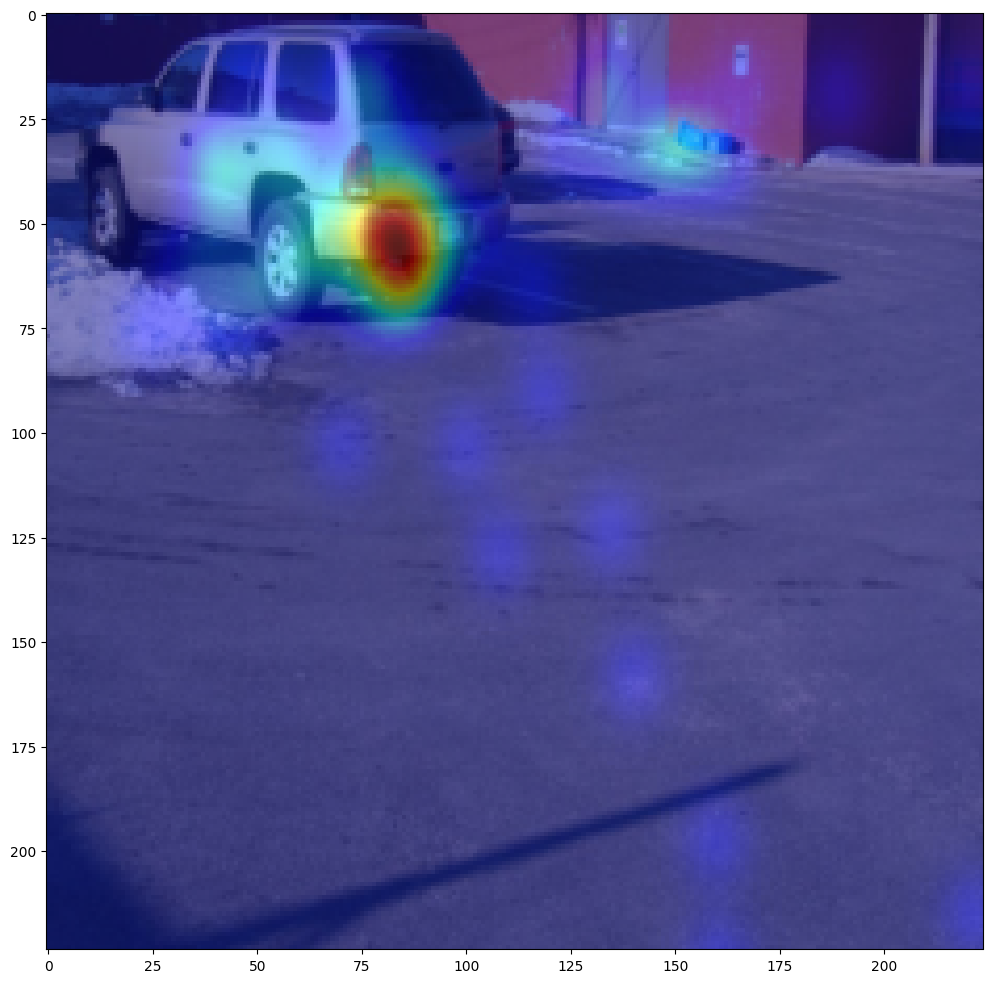

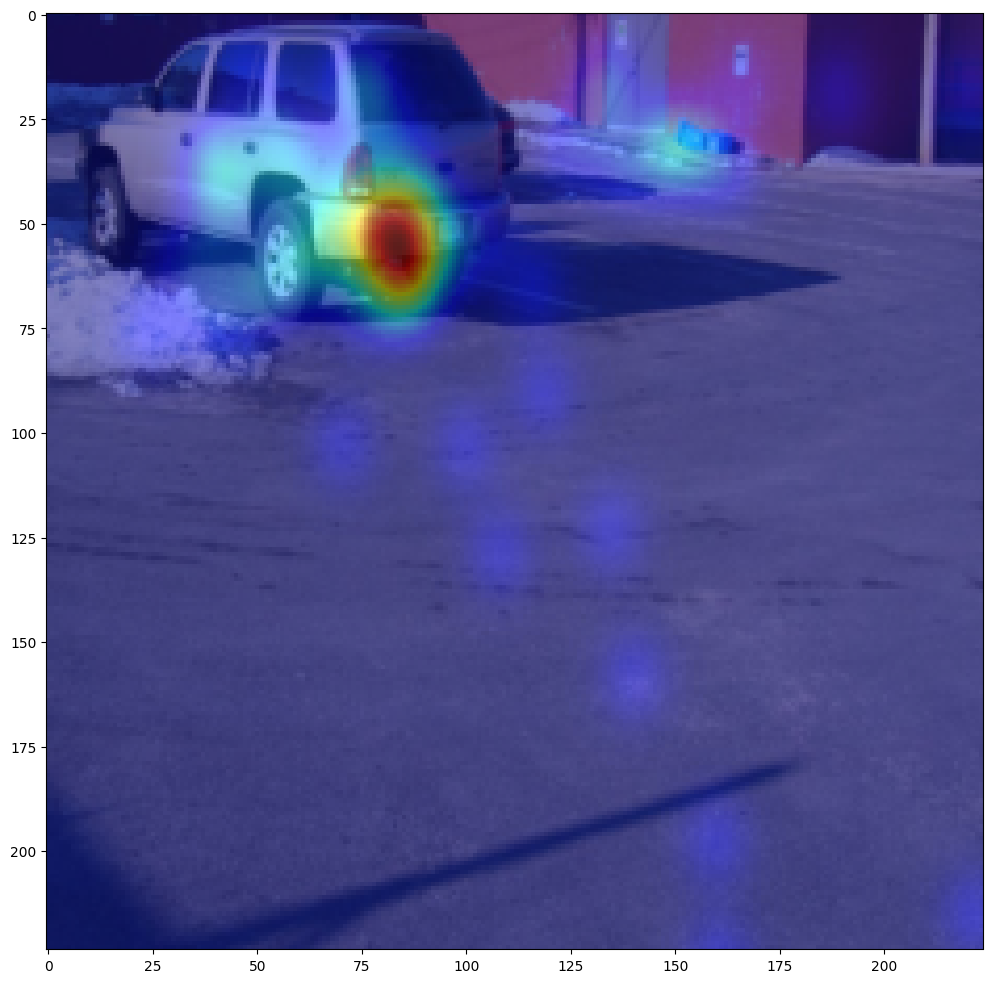

In [ ]:
# Example usage
# sample saliency maps for eye fixation: https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html
image_path = "car.jpeg"
heatmap_path = "car_heatmap.jpg"
heatmap = overlay_heatmap(image_path, heatmap_path)# Load the original image

image = load_image(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.tight_layout()
plt.show()

Comparison

In [ ]:
image_path = 'car.jpeg'
eye_fixation_heatmap_path = "car_heatmap.jpg"
heatmap_1 = get_CAM_heatmap(image_path, "gradcam++")
# heatmap_2 = get_CAM_heatmap(image_path, "scorecam")
# heatmap_2 = get_CAM_heatmap(image_path, "ablationcam")
# heatmap_2 = get_occlusion_sensitivity_heatmap(image_path)
heatmap_2 = eye_fixation_heatmap(image_path, eye_fixation_heatmap_path)
# heatmap_2 = get_lime_heatmap(image_path)

Model prediction: beach wagon


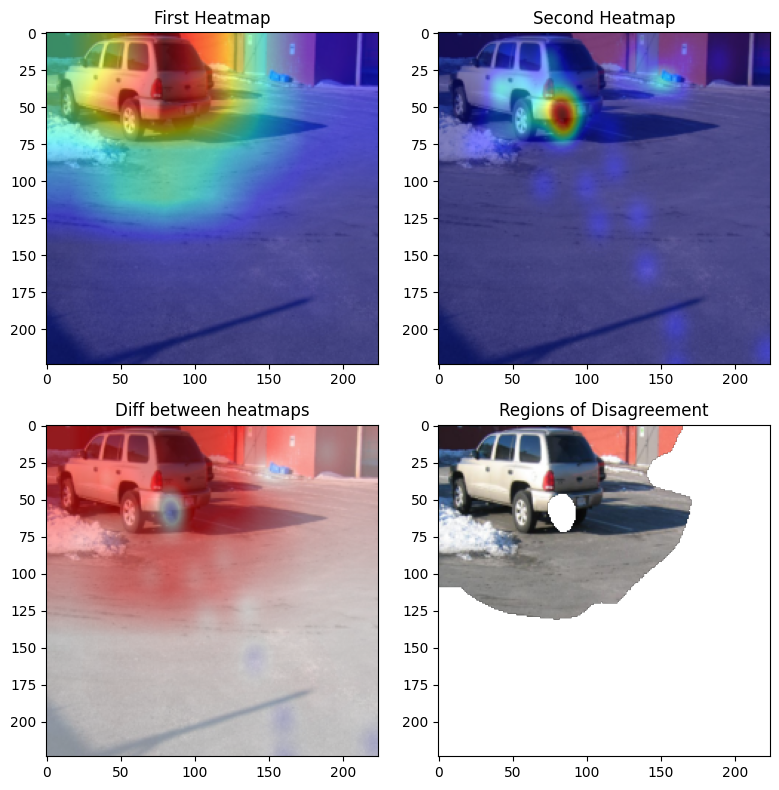

Mean Squared Error: 0.08778424416357565
SSIM: 0.24507644003016507
Correlation Coefficient: 0.5753075765432233


In [ ]:
original_image = load_image(image_path)

# Print the prediction to the console
model_output = model(preprocess(image_path).to(device))
predicted_class_index = torch.argmax(model_output).item()
predicted_class_label = imagenet_labels[predicted_class_index]
print(f"Model prediction: {predicted_class_label}")

diff = heatmap_1 - heatmap_2
# Visualize the heatmap
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(original_image)
axs[0, 0].imshow(heatmap_1, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[0, 0].set_title("First Heatmap")

axs[0, 1].imshow(original_image)
axs[0, 1].imshow(heatmap_2, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[0, 1].set_title("Second Heatmap")

axs[1, 0].imshow(original_image)
axs[1, 0].imshow(diff, cmap='seismic', vmin=-1, vmax=1, alpha=0.5)  # Overlay heatmap on image
axs[1, 0].set_title("Diff between heatmaps")

# Define threshold
threshold = 0.2
# Highlight regions of disagreement
disagreement = np.abs(diff) > threshold
cmap = ListedColormap(['white', 'none'])
axs[1, 1].imshow(original_image)
axs[1, 1].imshow(disagreement, cmap=cmap)
axs[1, 1].set_title("Regions of Disagreement")

plt.tight_layout()
plt.show()

# Compute Mean Squared Error
# focus: difference between corresponding pixels
mse = np.mean((heatmap_1 - heatmap_2)**2)
print(f"Mean Squared Error: {mse}")

# Compute Structural Similarity Index (SSIM) - perceptual similarity
# structural similarity -  differences between structures rather than simple pixels
# focus: Luminance, contrast, and structure.
  # 1: Perfect similarity.
  # 0: No similarity.
  # Negative values: Structural dissimilarity.
data_range = heatmap_1.max() - heatmap_1.min()
ssim_value, _ = ssim(heatmap_1, heatmap_2, full=True, data_range=data_range)
print(f"SSIM: {ssim_value}")

# Compute Correlation Coefficient - linear similarity
# measure the strength and direction of a linear relationship between two datasets
# focus: Overall linear dependency.
  # 1: Perfect positive correlation.
  # 0: No correlation.
  # −1: Perfect negative correlation.
correlation = np.corrcoef(heatmap_1.flatten(), heatmap_2.flatten())[0, 1]
print(f"Correlation Coefficient: {correlation}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Model prediction: beach wagon


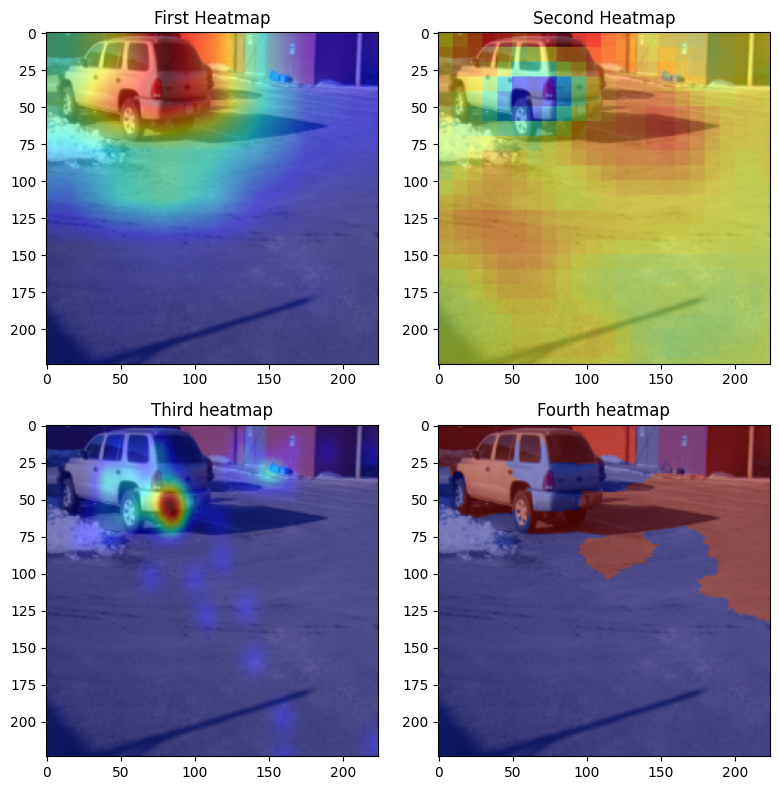

In [ ]:
# image_path = 'car.jpeg'
# eye_fixation_heatmap_path = "car_heatmap.jpg"
heatmap_1 = get_CAM_heatmap(image_path, "gradcam++")
# heatmap_2 = get_CAM_heatmap(image_path, "scorecam")
# heatmap_2 = get_CAM_heatmap(image_path, "ablationcam")
heatmap_2 = get_occlusion_sensitivity_heatmap(image_path)
heatmap_3 = eye_fixation_heatmap(image_path, eye_fixation_heatmap_path)
heatmap_4 = get_lime_heatmap(image_path)

original_image = load_image(image_path)

# Print the prediction to the console
model_output = model(preprocess(image_path).to(device))
predicted_class_index = torch.argmax(model_output).item()
predicted_class_label = imagenet_labels[predicted_class_index]
print(f"Model prediction: {predicted_class_label}")

# Visualize the heatmap
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(original_image)
axs[0, 0].imshow(heatmap_1, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[0, 0].set_title("First Heatmap")

axs[0, 1].imshow(original_image)
axs[0, 1].imshow(heatmap_2, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[0, 1].set_title("Second Heatmap")

axs[1, 0].imshow(original_image)
axs[1, 0].imshow(heatmap_3, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[1, 0].set_title("Third heatmap")

axs[1, 1].imshow(original_image)
axs[1, 1].imshow(heatmap_4, cmap='jet', alpha=0.5)  # Overlay heatmap on image
axs[1, 1].set_title("Fourth heatmap")

plt.tight_layout()
plt.show()
